<a href="https://colab.research.google.com/github/hmaldonado12/7506R-1C2024-GRUPO6/blob/main/tp2/RandomForest_7506R_TP2_GRUPO06_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
df_test_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')

df_train = df_train_original.copy()
df_test = df_test_original.copy()

# Preprocesamiento del dataset.

En esta notebook nos encargamos de efectuar la limpieza de dataset, la detección de datos incorrectos y/o vacíos, outliers, todo aquello que pueda imposibilitarnos a usar los modelos propuestos.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


Podemos ver que el dataset train no tiene datos faltantes.

In [ ]:
df_train[df_train.duplicated(keep=False)]

,ID,review_es,sentimiento


Tampoco tiene filas duplicadas.

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         8599 non-null   int64 
 1   review_es  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


In [ ]:
df_test[df_test.duplicated(keep=False)]

,ID,review_es


El mismo resultado para test.

# Bag of words

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def preprocess_text(text):
    # tokenizacion
    tokens = word_tokenize(text.lower())
    # elimino signos de puntuación
    tokens = [word for word in tokens if word not in string.punctuation]
    # elimino stopwords
    stop_words = set(stopwords.words('spanish'))
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df_train['review_es'] = df_train['review_es'].apply(preprocess_text)
df_test['review_es'] = df_test['review_es'].apply(preprocess_text)

In [ ]:
vectorizer = CountVectorizer()
x_train = vectorizer.fit_transform(df_train['review_es'])
y_train = df_train['sentimiento']

In [ ]:
test = vectorizer.transform(df_test['review_es'])

# Random Forest

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Utilizo Random Search CV para la búsqueda de los mejores hiperparámetros.



*   n_estimators: la cantidad de árboles que utilizará Random Forest.
*   criterion: criterio de decisión.
*   min_samples_leaf: el número de muestras mínimas para ser considerada una hoja.
*   min_samples_split: el número mínimo de muestras para dividir un nodo.





In [ ]:
randomforest = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"],
               "min_samples_leaf" : [1, 5, 10],
               "min_samples_split" : [2, 4, 10, 12, 16],
               "n_estimators": [10,20, 50] }

randomized_search =  RandomizedSearchCV(estimator=randomforest,
                              param_distributions = param_grid,
                              scoring="accuracy",
                              cv=5,
                              n_iter=1)
rs_fit = randomized_search.fit(X_train, Y_train)

Obteniendo el siguiente resultado

In [ ]:
rs_fit.best_params_

{'n_estimators': 50,
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'criterion': 'entropy'}

In [ ]:
print("accuracy en entrenamiento con cv: "+str(rs_fit.best_score_))

accuracy en entrenamiento con cv: 0.83605


Utilizaremos el dataset de validación para verificar qué tan bien le va a nuestro modelo con datos nuevos.

In [ ]:
best_model = rs_fit.best_estimator_
y_pred_rf = best_model.predict(X_val)

              precision    recall  f1-score   support

    negativo       0.82      0.80      0.81      4961
    positivo       0.81      0.82      0.82      5039

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



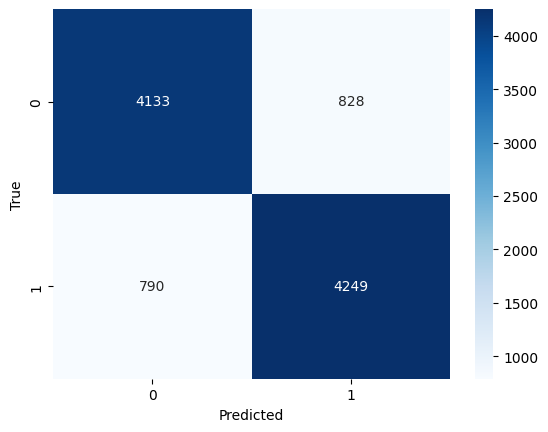

In [ ]:
#Creo matriz de confusión
tabla=confusion_matrix(Y_val,y_pred_rf)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(Y_val,y_pred_rf_cv_best))

Se obtiene un resultado bastante similar al que tuvimos en el entrenamiento. Por lo tanto parece ser un buen modelo.

Ahora realizo la prediccion con el dataset de test.

In [ ]:
pred = best_model.predict(test)

In [ ]:
submit = pd.DataFrame({'ID': df_test['ID'], 'sentimiento': pred})

Lo guardo para subirlo a Kaggle.

In [ ]:
submit.to_csv('/content/drive/My Drive/Colab Notebooks/RamdomForest.csv', index=False)

In [ ]:
submit

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,positivo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo
